In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
#Se utilizó de guía principalmente:
# https://www.tensorflow.org/tutorials/images/classification
#Y de forma paralela:
# https://keras.io/examples/vision/image_classification_from_scratch/

In [3]:
#Atención, bajar dataset previamente: https://www.kaggle.com/miljan/stanford-dogs-dataset-traintest
#extraerlo, y que la carpeta resultante quede en el mismo directorio que el notebook.
train_dir = 'archive/cropped/train'
test_dir = 'archive/cropped/test'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9360003137243149933
]


In [5]:
#Test GPU
tf.config.list_physical_devices('GPU')
#Si aca no les aparece una lista vacia, y les corren las cosas sin errores, en particular sin este:
# "CUDA runtime implicit initialization on GPU:0 failed." entonces les anda la GPU.

[]

In [6]:
#Test GPU
tf.test.is_built_with_cuda()

True

In [7]:
#Test GPU
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [8]:
#Version tensorflow 2.3 como mínimo para tf.keras.preprocessing.image_dataset_from_directory (o instalar tf-nightly a la par)
print(tf.__version__)

2.4.0


In [5]:
#Parte mia
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( 
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=40,
    zoom_range = 0.1,
    rescale=1./255,
    validation_split=0.33)
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="training"
)

# Valid generator

valid_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="validation"
)

# Test generator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 8040 images belonging to 120 classes.
Found 3960 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


In [6]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [7]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [8]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [9]:
#Xception model con un par de cambios 
from tensorflow.keras.applications.xception import Xception
base_model = Xception(weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 55s 1us/step


In [15]:
from tensorflow.keras.models import Model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- 
predictions = layers.Dense(120, activation='softmax')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False
    
# this is the model we will train
xception = Model(inputs=base_model.input, outputs=predictions)
xception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
xception.fit(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    verbose=1,
                    callbacks=[learning_rate_reduction]
)

C:\Users\Nico\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
125/125 [==============================] - 934s 7s/step - loss: 2.0782 - accuracy: 0.5229 - val_loss: 0.9376 - val_accuracy: 0.7275
Epoch 2/10
125/125 [==============================] - 892s 7s/step - loss: 0.7727 - accuracy: 0.7726 - val_loss: 0.8476 - val_accuracy: 0.7426
Epoch 3/10
125/125 [==============================] - 831s 7s/step - loss: 0.6818 - accuracy: 0.7885 - val_loss: 0.9000 - val_accuracy: 0.7339
Epoch 4/10
125/125 [==============================] - 829s 7s/step - loss: 0.5830 - accuracy: 0.8138 - val_loss: 0.8717 - val_accuracy: 0.7480
Epoch 5/10
125/125 [==============================] - 934s 7s/step - loss: 0.5493 - accuracy: 0.8220 - val_loss: 0.8517 - val_accuracy: 0.7579
Epoch 6/10
125/125 [==============================] - 948s 8s/step - loss: 0.5232 - accuracy: 0.8312 - val_loss: 0.8901 - val_accuracy: 0.7590
Epoch 7/10
125/125 [==============================] - 924s 7s/step - loss: 0.4566 - accuracy: 0.8508 - val_loss: 0.8701 - val_accuracy: 0.7582

In [24]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
loss, acc = xception.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST, verbose=0)
print(loss, acc)

0.5536444187164307 0.8506296873092651


In [18]:
#Guardo el modelo entrenado
xception_model_json = xception.to_json()
with open("xcept_model.json", "w") as json_file:
    json_file.write(xception_model_json)
# serialize weights to HDF5
xception.save_weights("weight_model.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
#Para cargar el modelo entrenado
# load json and create model
from tensorflow.keras.models import model_from_json
json_file = open('xcept_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
xception_model = model_from_json(loaded_model_json)
# load weights into new model
xception_model.load_weights("weight_model.h5")
print("Loaded model from disk")

Loaded model from disk
accuracy: 85.06%


In [ ]:
#Compilacion del modelo loadeado
xception_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
score = xception_model.evaluate(test_generator, steps=STEP_SIZE_TEST, verbose=0)
print("%s: %.2f%%" % (xception_model.metrics_names[1], score[1]*100))

In [27]:
#xception_model.summary()

In [31]:
predictions = xception_model.predict(test_generator,steps = STEP_SIZE_TEST, verbose = 0)

In [37]:
dogs_breeds = test_datagen.class_names
print(dogs_breeds)

AttributeError: 'ImageDataGenerator' object has no attribute 'class_names'

In [45]:
tf.keras.np_utils.probas_to_classes(predictions)

AttributeError: module 'tensorflow.keras' has no attribute 'np_utils'

In [46]:
y_classes = predictions.argmax(axis=-1)
y_classes

array([  0,   0,   0, ..., 119, 119, 119], dtype=int64)

In [86]:
#Creo train_ds solamente para tener las classnames
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir)
breeds = test_ds.class_names

Found 8580 files belonging to 120 classes.


In [95]:
results_by_class = []
count = 0
for pred in y_classes:
    results_by_class.append((breeds[pred],count))
    count+=1

In [ ]:
results_by_class

In [101]:
import os
os.listdir("archive/cropped/test")
all_filenames = []
for breed in breeds:
    pictures = os.listdir("archive/cropped/test/" + breed)
    for pic in pictures:
        all_filenames.append((pic,breed))

In [ ]:
all_filenames

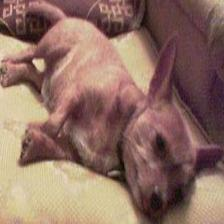

In [155]:
from IPython.display import Image
pos_selected = 29
Image(filename= 'archive/cropped/test/'+ all_filenames[pos_selected][1] + '/'+all_filenames[pos_selected][0]) 

In [156]:
print("Predicción: " + results_by_class[pos_selected][0] + "\nRaza Verdadera: " + all_filenames[pos_selected][1])

Predicción: n02099849-Chesapeake_Bay_retriever
Raza Verdadera: n02085620-Chihuahua
